<a href="https://colab.research.google.com/github/AhmedAbdallah142/Pattern-Recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
X = np.empty((0,10304))
Y = np.empty(0);
for i in range (1,41):
  for j in range (1,11):
    img = Image.open('gdrive/My Drive/data_faces/s{}/{}.pgm'.format(i,j))
    X = np.append(X, [np.asarray(img).flatten()],axis = 0)
    Y = np.append(Y,i)
print(X)

[[ 48.  49.  45. ...  47.  46.  46.]
 [ 60.  60.  62. ...  32.  34.  34.]
 [ 39.  44.  53. ...  29.  26.  29.]
 ...
 [125. 119. 124. ...  36.  39.  40.]
 [119. 120. 120. ...  89.  94.  85.]
 [125. 124. 124. ...  36.  35.  34.]]


In [ ]:
def data_Split():
  X_test = np.empty((0,10304))
  X_train = np.empty((0,10304))
  Y_train = np.empty(0)
  Y_test = np.empty(0)
  for i in range (1,41):
    for j in range (1,11):
      img = Image.open('gdrive/My Drive/data_faces/s{}/{}.pgm'.format(i,j))
      if(j%2 == 0):
        X_train = np.append(X_train, [np.asarray(img).flatten()],axis = 0)
        Y_train = np.append(Y_train,i)
      else:
        X_test = np.append(X_test, [np.asarray(img).flatten()],axis = 0)
        Y_test = np.append(Y_test,i)   
  return X_train,Y_train,X_test,Y_test

In [ ]:
# Bonus Part
def Bonus():
  X_test = np.empty((0,10304))
  X_train = np.empty((0,10304))
  Y_train = np.empty(0)
  Y_test = np.empty(0)
  for i in range (1,41):
    for j in range (1,11):
      img = Image.open('gdrive/My Drive/data_faces/s{}/{}.pgm'.format(i,j))
      if(j <= 7):
        X_train = np.append(X_train, [np.asarray(img).flatten()],axis = 0)
        Y_train = np.append(Y_train,i)
      else:
        X_test = np.append(X_test, [np.asarray(img).flatten()],axis = 0)
        Y_test = np.append(Y_test,i)   
  return X_train,Y_train,X_test,Y_test

In [ ]:
def PCA(data,alpha):

  column_means = data.mean(axis=0)
  Z = data - column_means
  
  cov = np.cov(np.transpose(Z))

  eigen_values , eigen_vectors = np.linalg.eigh(cov)
  sorted_index = eigen_values.argsort()[::-1]
 
  sorted_eigenvalue = eigen_values[sorted_index]
  sorted_eigenvectors = eigen_vectors[:,sorted_index]

  total_sum = np.sum(sorted_eigenvalue)
  cur_sum = 0

  for i in range (len(sorted_eigenvalue)):
    cur_sum += sorted_eigenvalue[i]
    f = (cur_sum)/(total_sum)
    if(f >= alpha):
      return sorted_eigenvectors[:,:i]

In [ ]:
def LDA(data,label):
  data_dimension = data.shape[1]
  labels = np.unique(label)
  data_mean = data.mean(axis = 0);
  S = np.zeros((data_dimension,data_dimension))
  SB = np.zeros((data_dimension, data_dimension))

  for l in labels:
    class_data = data[label == l]
    class_mean = class_data.mean(axis = 0)
    S += np.dot(np.transpose(class_data - class_mean) , (class_data - class_mean))
    SB += class_data.shape[0]*np.dot((class_mean - data_mean),np.transpose(class_mean - data_mean)) # between class scatter matrix

  eigen_values , eigen_vectors = np.linalg.eigh(np.dot(np.linalg.inv(S),SB))
  return eigen_vectors[:,(data_dimension-labels.size+1):]

In [ ]:
def KNN_Accuracy(X_train,Y_train,X_test,Y_test,N):
  knn = KNeighborsClassifier(n_neighbors = N).fit(X_train,Y_train)
  yhat = knn.predict(X_test)
  return metrics.accuracy_score(Y_test, yhat),Y_test==yhat

In [ ]:
def KTuning(X_train,Y_train,X_test,Y_test):
  mean_acc = np.zeros(4)
  for index , i in enumerate(range(1,8,2)): # setting k to 1,3,5,7
      mean_acc[index] = KNN_Accuracy(X_train,Y_train,X_test,Y_test,i)[0]
  #plotting the data
  loc = np.arange(1,8,step=2.0)
  plt.figure(figsize = (10, 6))
  plt.plot(range(1,8,2), mean_acc)
  plt.xticks(loc)
  plt.xlabel('Number of Neighbors')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
#call the Tuning func with PCA
def PCA_Projection(X_train,X_test,alpha):
  column_means_train = X_train.mean(axis=0)
  Z_train = X_train - column_means_train

  column_means_test = X_test.mean(axis=0)
  Z_test = X_test - column_means_test
  P = PCA(X_train,alpha)
  D_train = np.dot(Z_train,P)
  D_test  = np.dot(Z_test,P)
  return D_train,D_test

In [ ]:
#call the Tuning func with LDA
def LDA_Projection(X_train,X_test,Y_train):
  P = LDA(X_train,Y_train)
  X_train = np.dot(X_train,P)
  X_test = np.dot(X_test,P)
  return X_train,X_test

In [ ]:
def Solve(X_train,Y_train,X_test,Y_test):
  print("PCA Results: \n-------------\n")
  alpha = [0.8,0.85,0.9,0.95]
  for a in alpha:
    print(f'\nfor alpha = {a}\n')
    D_train ,D_test =  PCA_Projection(X_train,X_test,a)
    KTuning(D_train,Y_train,D_test,Y_test)
  print("\nLDA Results: \n-------------\n")
  D_train ,D_test = LDA_Projection(X_train,X_test,Y_train)
  KTuning(D_train,Y_train,D_test,Y_test)

6. Classifier Tunning :
 ------------------------

PCA Results: 
-------------


for alpha = 0.8



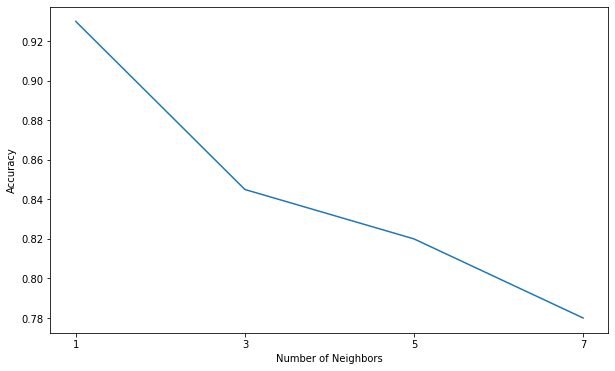


for alpha = 0.85



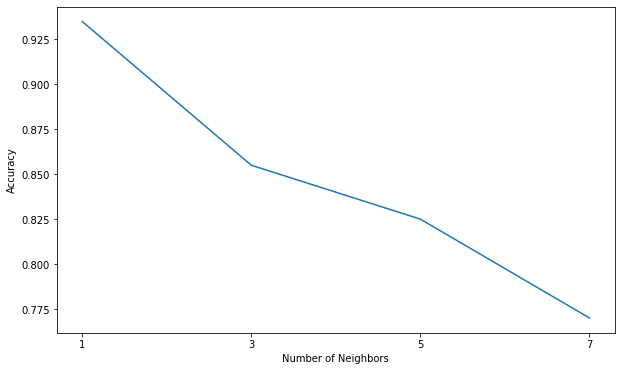


for alpha = 0.9



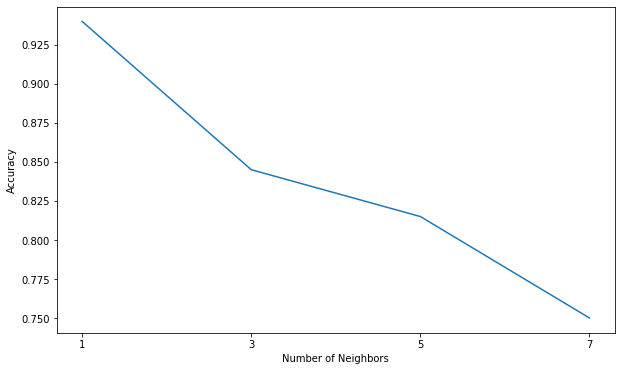


for alpha = 0.95



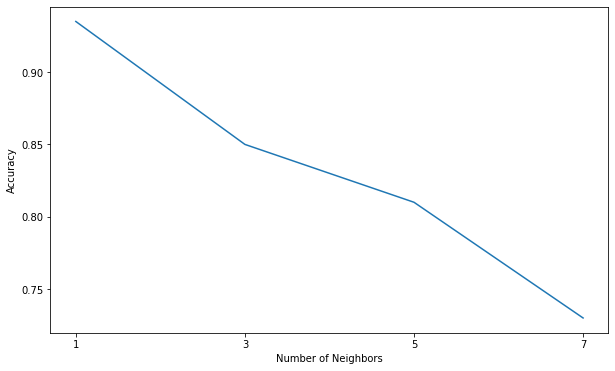


LDA Results: 
-------------



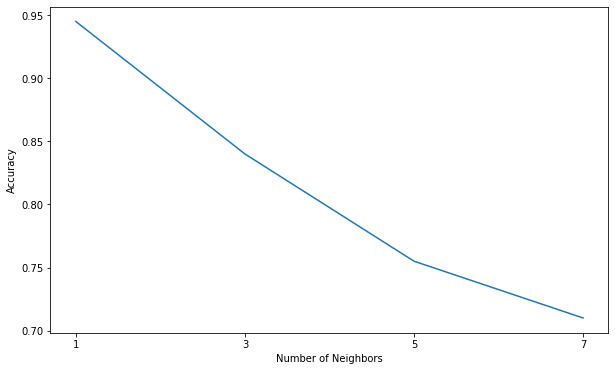

8. Classifier Tunning Bonus Part :
 ------------------------

PCA Results: 
-------------


for alpha = 0.8



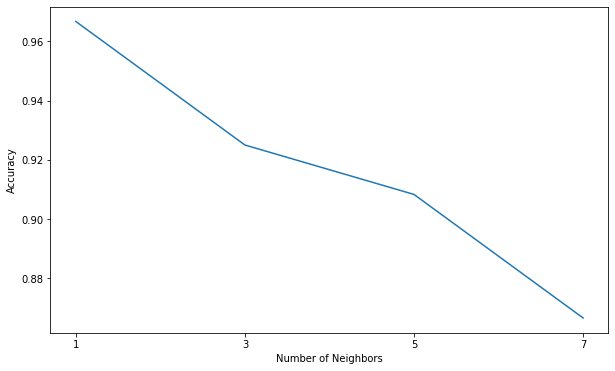


for alpha = 0.85



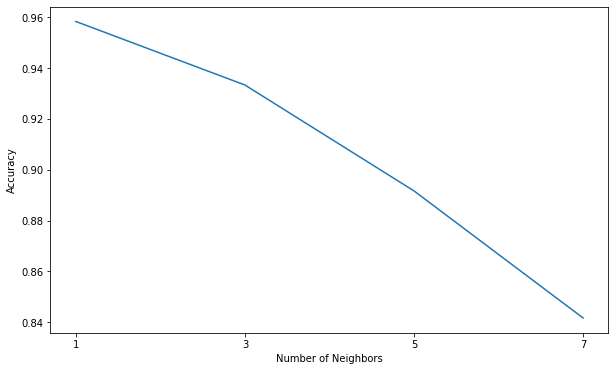


for alpha = 0.9



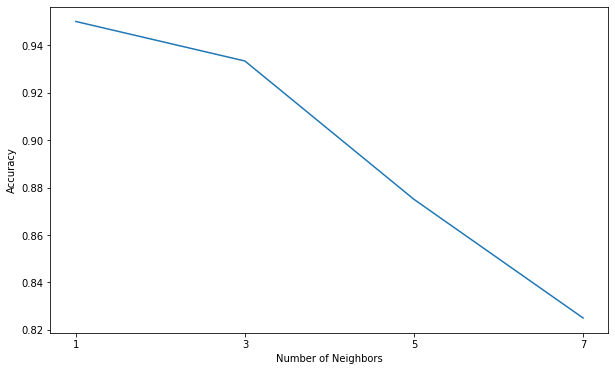


for alpha = 0.95



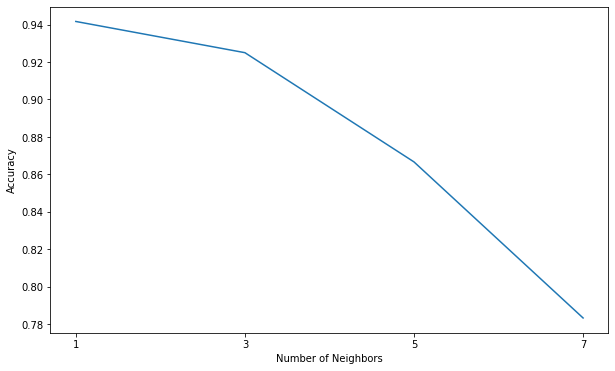


LDA Results: 
-------------



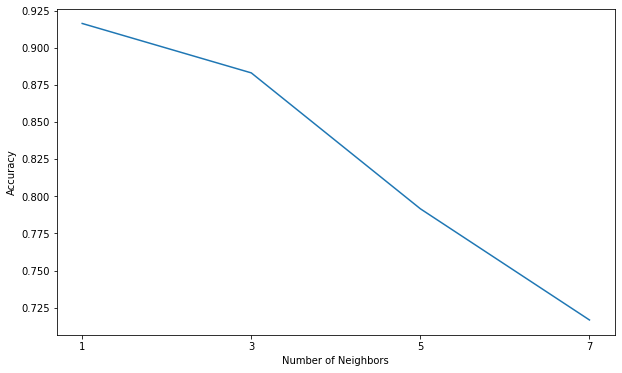

In [ ]:
print("6. Classifier Tunning :\n ------------------------\n")
X_train,Y_train,X_test,Y_test = data_Split()
Solve(X_train,Y_train,X_test,Y_test)

print("8. Classifier Tunning Bonus Part :\n ------------------------\n")
XB_train,YB_train,XB_test,YB_test = Bonus()
Solve(XB_train,YB_train,XB_test,YB_test)

In [ ]:
# Generate non-faces data
non_faces = np.empty((0,10304))
num = 0
for i in range (1,1001):
  if(i<10):
    img = Image.open('gdrive/My Drive/flower/flower_000{}.jpg'.format(i))
  elif(i<100):
    img = Image.open('gdrive/My Drive/flower/flower_00{}.jpg'.format(i))
  else:
    img = Image.open('gdrive/My Drive/flower/flower_0{}.jpg'.format(i))
  imgGray = img.convert('L')
  img_array = np.asarray(imgGray)
  if(img_array.shape[0] >= 112 and img_array.shape[1] >= 92):
    non_faces = np.append(non_faces, [img_array[:112,:92].flatten()],axis = 0)
    num=num+1
  if(num==400):
    break


print(non_faces.shape)
print(non_faces)

(400, 10304)
[[ 96.  93.  90. ...   9.   9.   8.]
 [ 32.  22.  16. ...  54.  63.  54.]
 [ 82.  82.  81. ...  98.  99.  99.]
 ...
 [  0.   0.   0. ...  38.  40.  43.]
 [229. 214. 178. ...  74.  59.  49.]
 [ 30.  32.  34. ...  35.  34.  32.]]


In [ ]:
def NonFacePlot(X,Y):
  plt.figure(figsize = (10, 6))
  plt.plot(X,Y)
  plt.xlabel('Number of Non Faces Images')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
def showCases(prediction,data_test):
  success = 2
  fail = 2
  for index , value in enumerate(prediction):
    if success == 0 and fail == 0:
      break;
    if value:
      if success > 0:
        success-=1
        print("\nSuccess case :\n")
        plt.figure()
        plt.imshow(data_test[index].reshape(112,92))
        plt.show()
    else:
      if fail > 0:
        fail-= 1
        print("\nFail case :\n")
        plt.figure()
        plt.imshow(data_test[index].reshape(112,92))
        plt.show()

In [ ]:
X_train,Y_train,X_test,Y_test = data_Split()

7. Faces vs non Faces:
 ------------------------
test with fixed faces data 400 image 
note: data train size = data test size

 Number of Non Faces Images = 100

PCA Show Cases: 
-------------


for alpha = 0.8


Success case :



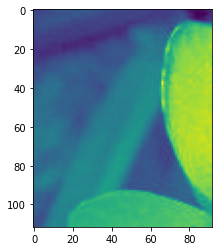


Success case :



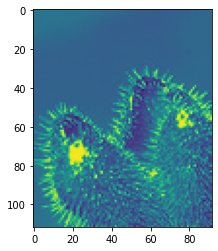


Fail case :



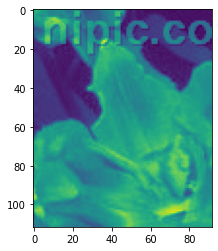


Fail case :



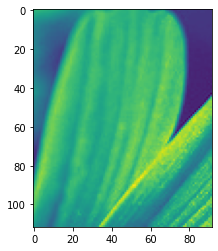


for alpha = 0.85


Success case :



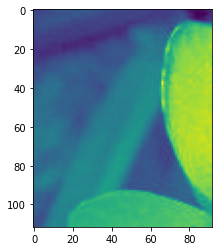


Success case :



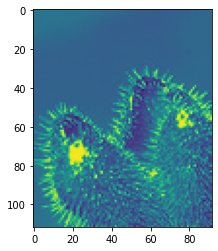


Fail case :



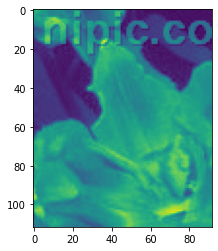


Fail case :



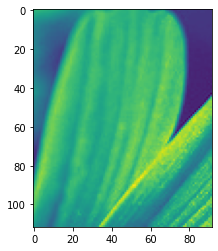


for alpha = 0.9


Success case :



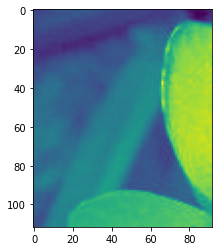


Success case :



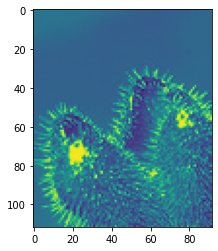


Fail case :



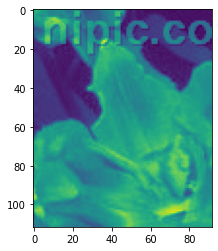


Fail case :



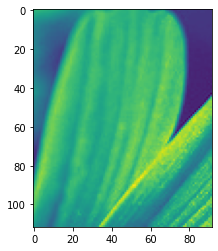


for alpha = 0.95


Success case :



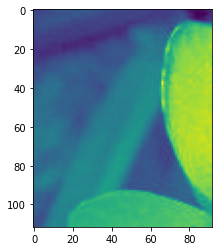


Success case :



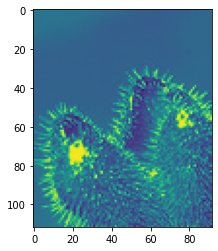


Fail case :



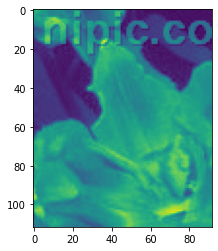


Fail case :



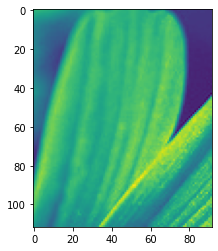

LDA Show Cases: 
-------------


Fail case :



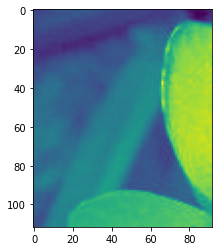


Fail case :



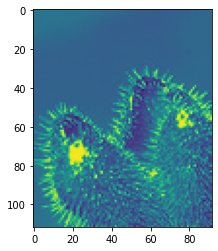


Success case :



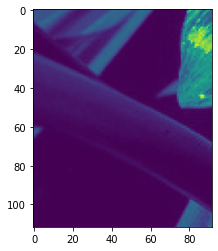


Success case :



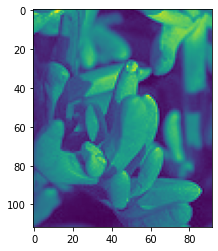


 Number of Non Faces Images = 200

PCA Show Cases: 
-------------


for alpha = 0.8


Success case :



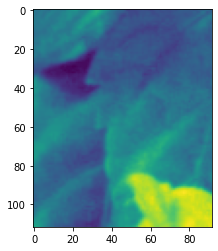


Success case :



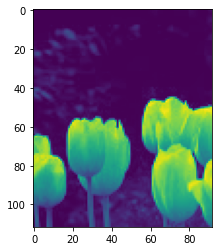


Fail case :



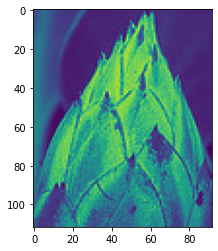


Fail case :



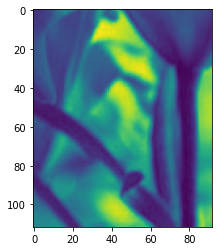


for alpha = 0.85


Success case :



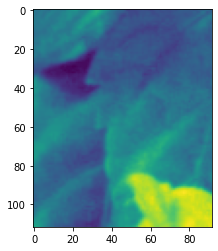


Success case :



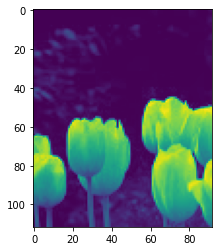


Fail case :



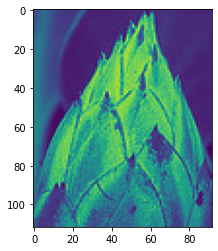


Fail case :



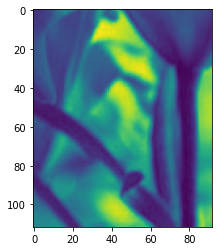


for alpha = 0.9


Success case :



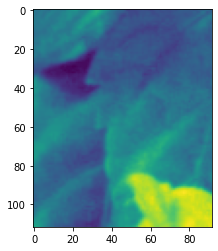


Success case :



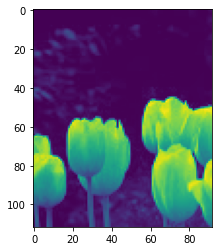


Fail case :



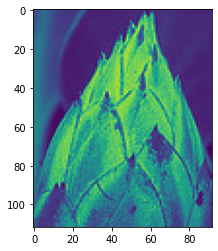


Fail case :



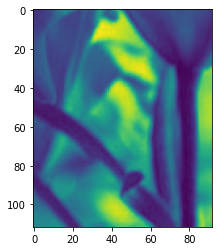


for alpha = 0.95


Success case :



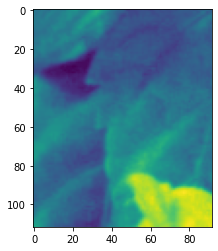


Success case :



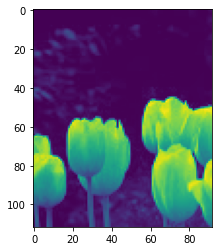


Fail case :



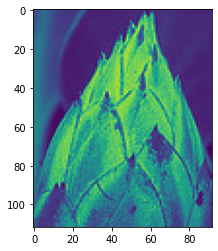


Fail case :



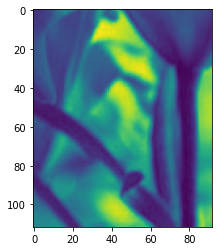

LDA Show Cases: 
-------------


Fail case :



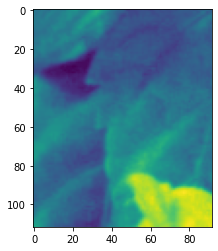


Success case :



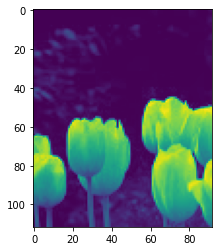


Fail case :



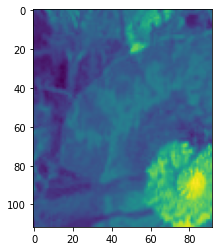


Success case :



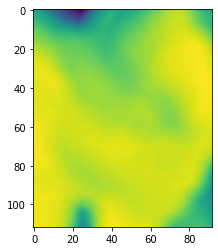


 Number of Non Faces Images = 300

PCA Show Cases: 
-------------


for alpha = 0.8


Success case :



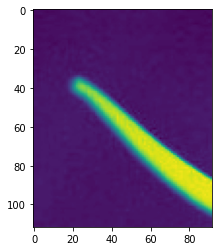


Success case :



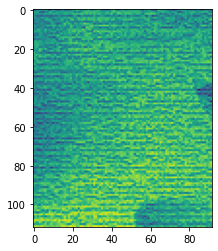


Fail case :



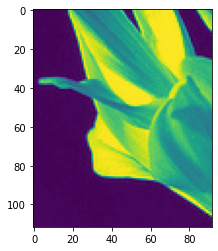


Fail case :



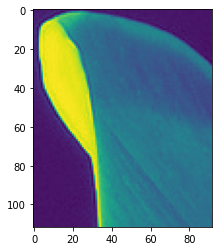


for alpha = 0.85


Success case :



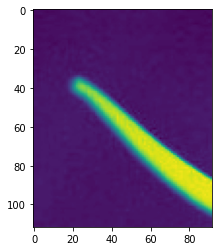


Success case :



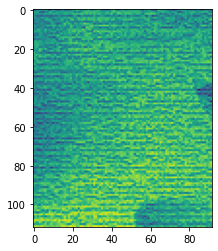


Fail case :



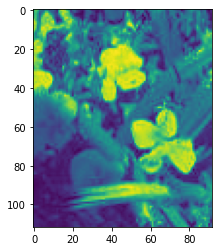


Fail case :



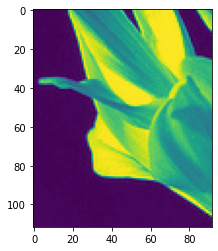


for alpha = 0.9


Success case :



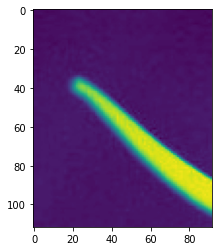


Success case :



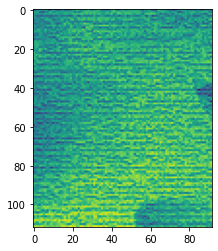


Fail case :



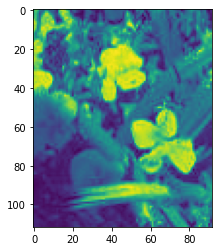


Fail case :



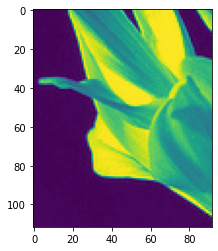


for alpha = 0.95


Success case :



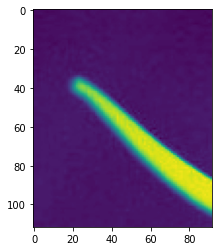


Success case :



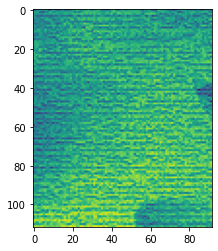


Fail case :



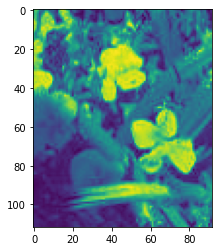


Fail case :



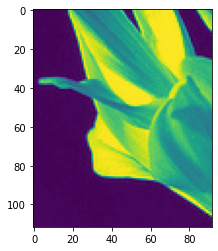

LDA Show Cases: 
-------------


Fail case :



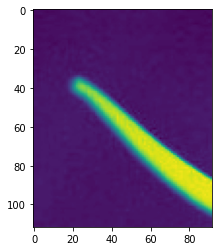


Success case :



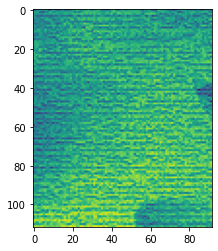


Success case :



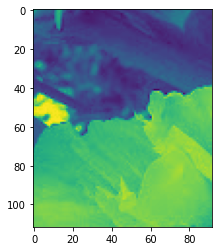


Fail case :



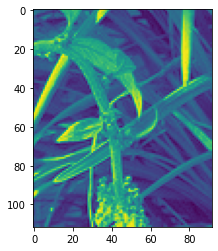


 Number of Non Faces Images = 400

PCA Show Cases: 
-------------


for alpha = 0.8


Success case :



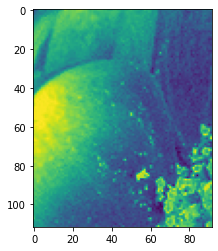


Success case :



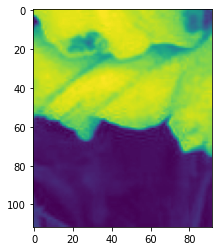


Fail case :



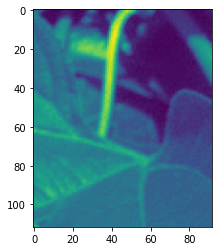


Fail case :



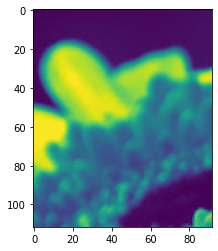


for alpha = 0.85


Success case :



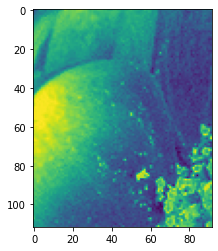


Success case :



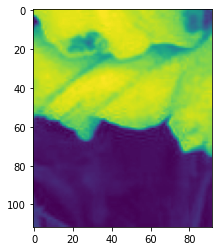


Fail case :



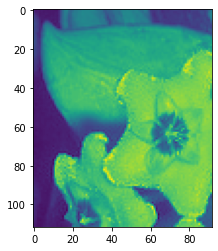


Fail case :



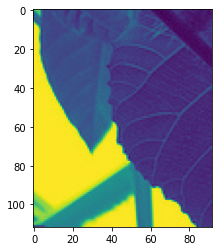


for alpha = 0.9


Success case :



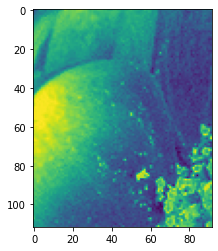


Success case :



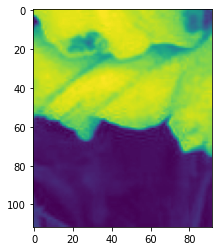


Fail case :



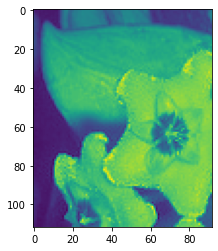


Fail case :



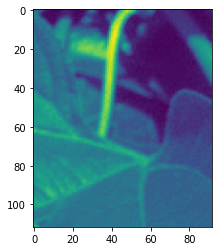


for alpha = 0.95


Success case :



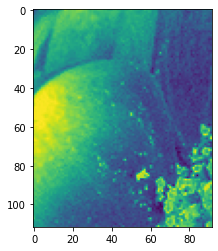


Success case :



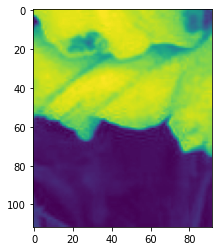


Fail case :



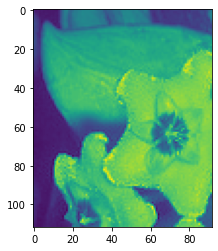


Fail case :



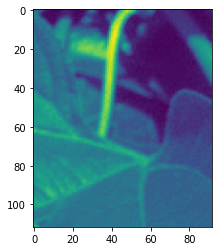

LDA Show Cases: 
-------------


Fail case :



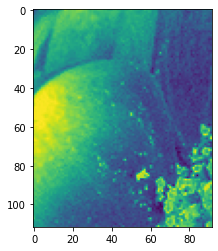


Fail case :



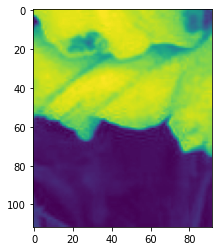


Success case :



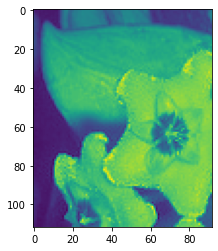


Success case :



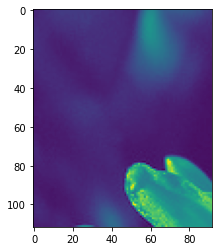


PCA Results: 
-------------


for alpha = 0.8



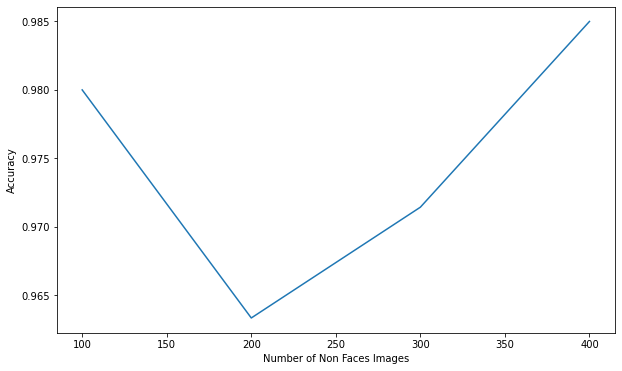


for alpha = 0.85



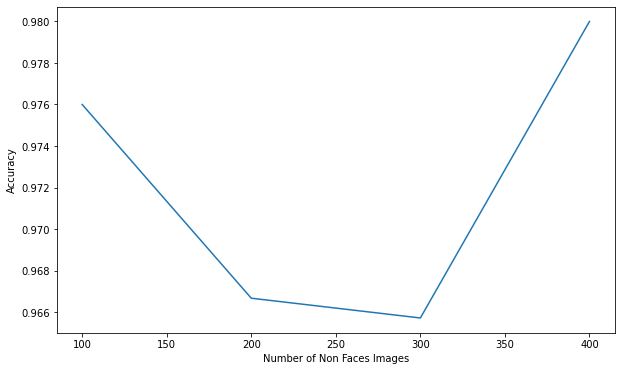


for alpha = 0.9



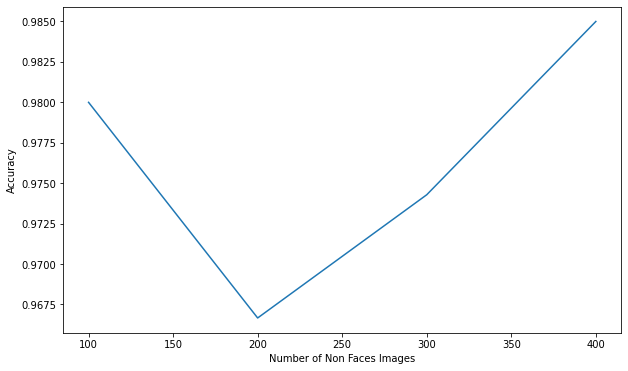


for alpha = 0.95



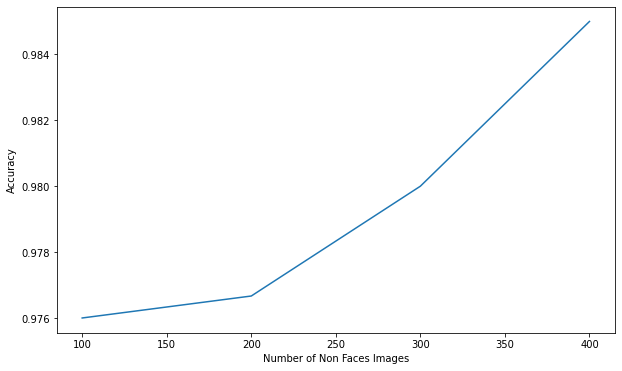

LDA Results: 
-------------



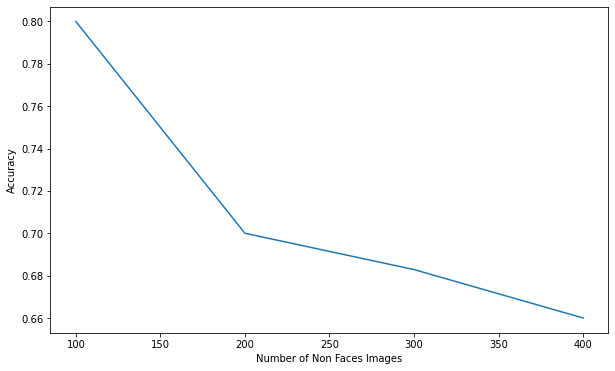

In [ ]:
print("7. Faces vs non Faces:\n ------------------------\ntest with fixed faces data 400 image \nnote: data train size = data test size")

alpha = [0.8,0.85,0.9,0.95]
PCA_Results = np.zeros((4,4))
LDA_Results = np.zeros(4)
for index,length in enumerate(range(100 , 401 , 100)):
  data_train = np.concatenate((non_faces[:int(length/2),:],X_train))
  data_test = np.concatenate((non_faces[int(length/2):length,:],X_test))
  label_train = np.concatenate((np.full(int(length/2),-1),np.full(200,1)))
  label_test = np.concatenate((np.full(int(length/2),-1),np.full(200,1)))
  print(f'\n Number of Non Faces Images = {length}\n')
  print("PCA Show Cases: \n-------------\n")
  for i,a in enumerate(alpha):
    D_train ,D_test =  PCA_Projection(data_train,data_test,a)
    PCA_Results[i,index],prediction = KNN_Accuracy(D_train,label_train,D_test,label_test,1)
    print(f'\nfor alpha = {a}\n')
    showCases(prediction,data_test)
  D_train ,D_test =  LDA_Projection(data_train,data_test,label_train)
  LDA_Results[index],prediction = KNN_Accuracy(D_train,label_train,D_test,label_test,1)
  print("LDA Show Cases: \n-------------\n")
  showCases(prediction,data_test)

print("\nPCA Results: \n-------------\n")
for i,a in enumerate(alpha):
  print(f'\nfor alpha = {a}\n')
  NonFacePlot(range(100 , 401 , 100),PCA_Results[i])

print("LDA Results: \n-------------\n")
NonFacePlot(range(100 , 401 , 100),LDA_Results)


Success case :



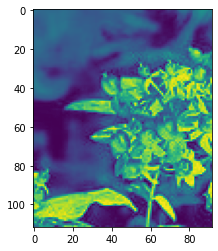


Success case :



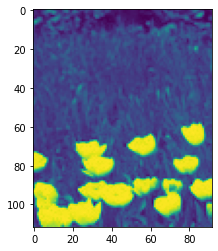


Fail case :



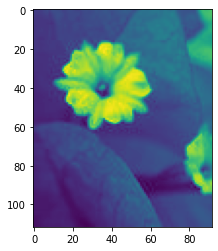


Fail case :



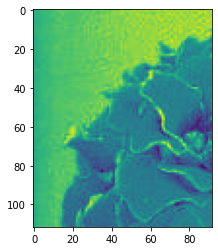

In [ ]:
showCases(np.array([True,True,False,False,True,False,False,False]),non_faces)